<a href="https://colab.research.google.com/github/tuananh1006/Torch_Practice/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Familar With Processing Image

In [1]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 99% 215M/218M [00:02<00:00, 108MB/s]
100% 218M/218M [00:02<00:00, 95.8MB/s]


In [2]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [8]:
#import transforms and compose
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
import numpy as np

In [11]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

In [80]:
transform=transforms.Compose(
    [ transforms.Resize((256),interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
    ]
)

In [81]:
import torchvision
trainset=torchvision.datasets.ImageFolder(root='./training_set/training_set',transform=transform)
testset=torchvision.datasets.ImageFolder(root='./test_set/test_set',transform=transform)

In [82]:
len(testset)

2023

In [83]:
from torch.utils.data import DataLoader
trainloader=DataLoader(trainset,batch_size=4,shuffle=True,num_workers=0)
testloader=DataLoader(testset,batch_size=2023,shuffle=False,num_workers=0)

In [84]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [85]:
images.shape

torch.Size([4, 3, 224, 224])

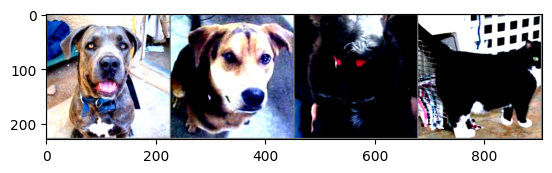

In [86]:
imshow(torchvision.utils.make_grid(images))

In [87]:
#Download Pretrain Network
model=torchvision.models.alexnet(pretrained=True)

In [88]:
#freeze all layer
for param in model.parameters():
  param.requires_grad=False

In [89]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [96]:
import torch.nn as nn
from typing import OrderedDict
new_classifier = nn.Sequential(
    *model.classifier[:3],  # Keep the first 3 layers
    nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(4096, 1)),
        ('sigmoid', nn.Sigmoid())
    ])),  # Your new sequential layer
    *model.classifier[6:]  # Keep the layers from index 6 onwards
)

In [97]:
import torch
loss_fn=nn.BCELoss()
#loss_fn=nn.BCEWithLogitsLoss()
losses=[]
#optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=2

In [98]:
for epoch in range(epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels=data
    optimizer.zero_grad()
    outputs=model(inputs).squeeze(1)
    loss=loss_fn(outputs,labels.float())
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  print(f'epoch:{epoch+1},loss:{loss.item()}')

epoch:1,loss:0.00047810430987738073
epoch:2,loss:1.6056663990020752


<Axes: >

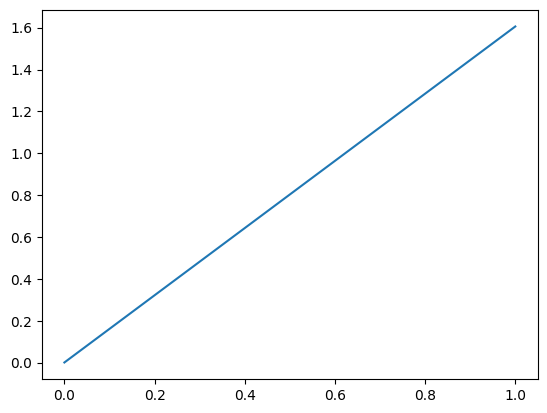

In [99]:
import seaborn as sns
sns.lineplot(x=range(epochs),y=losses)

In [100]:
from sklearn.metrics import accuracy_score
with torch.no_grad():
  for data in testloader:
    images,labels=data
    outputs=model(images).round().squeeze(1)
    print(accuracy_score(labels,outputs.numpy()))

0.9599604547701434


In [ ]:
y_test=[]
y_test_pred=[]
with torch.no_grad():
  for data in testloader:
    images,labels=data
    outputs=model(images).round().squeeze(1)
    y_test.extend(labels.numpy())
    y_test_pred.extend(outputs.numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_test_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)


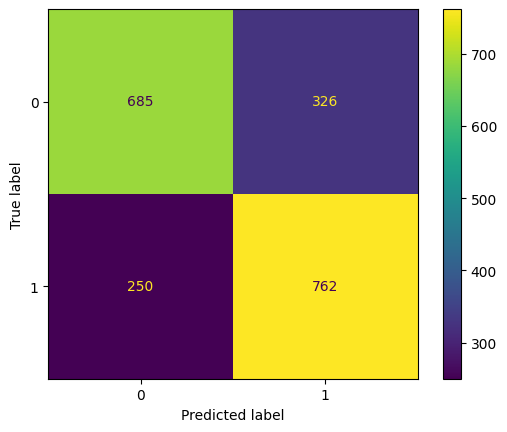

In [ ]:
disp.plot()